## Ideas for scouting analysis:


- Time series analysis
    - Hitting ability
    - Runs scoring ability
    - Pressure soaking ability (entry points, exit points)
    - Strike rotation
- Time series forecasting

## Problem Statement:

### Auction: Players who can fulfil the role of pinch hitter in powerplay for SRH?

- Player analysis
- Team analysis
- Batsmen evaluation (ranking) for that particular role

### Keywords: Pinch hitter, Powerplay, SRH
- Quantifying these words:
    - Pinch Hitter = High SR, Low balls_per_boundary, Decent Runs, Decent Balls Faced
    - Powerplay = 1-6 overs
    - SRH = Analysis By Team

In [19]:
import math
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

import matplotlib.pyplot as plt

In [20]:
deliveries = pd.read_csv('deliveries.csv')
matches = pd.read_csv('matches.csv')

## Terminology Used:
- SR = Strike Rate = Scoring rate for each ball
- RPI = Runs Per Innings = Runs scored per each innings including outs/not-outs
- BPB = Balls Per Boundary = No of balls for each six or a four
- BPD = Balls Per Dismissal = Average number of balls faced per each dismissal

## Part 1: Player Statistics

### 1.1 : Extract player-level statistics
### 1.2 : Determine player type from the above stats

In [21]:
def balls_per_dismissal(balls, dismissals):
    if dismissals > 0:
        return balls/dismissals
    else:
        return balls/1 
    
def balls_per_boundary(balls, boundaries):
    if boundaries > 0:
        return balls/boundaries
    else:
        return balls/1 

def playerStatistics(df):
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'match_id'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [22]:
df = playerStatistics(deliveries)

In [23]:
df.head()

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,23,280,196,15,61,83,20,1,16,15,142.857143,12.173913,13.066667,6.322581
1,A Chandila,2,4,7,1,3,4,0,0,0,0,57.142857,2.000000,7.000000,7.000000
2,A Chopra,6,53,75,5,45,21,2,0,7,0,70.666667,8.833333,15.000000,10.714286
3,A Choudhary,3,25,20,2,4,13,1,0,1,1,125.000000,8.333333,10.000000,10.000000
4,A Flintoff,3,62,57,2,24,23,2,1,5,2,108.771930,20.666667,28.500000,8.142857


### 1.3 : Performance in different phases of play

In [24]:
def phase(over):
    if over <= 6:
        return 'Powerplay'
    elif over <= 15:
        return 'Middle'
    else:
        return 'Death'

In [25]:
deliveries['phase'] = deliveries['over'].apply(lambda x: phase(x))

In [26]:
def phasesOfplay(df, current_phase):
    
    df = df[df.phase == current_phase]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'match_id'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [27]:
pp_df = phasesOfplay(deliveries, 'Powerplay')
mid_df = phasesOfplay(deliveries, 'Middle')
dth_df = phasesOfplay(deliveries, 'Death')

In [28]:
pp_df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,1,5,7,1,5,1,0,0,1,0,71.428571,5.0,7.0,7.00
1,A Chopra,5,27,41,2,26,11,0,0,4,0,65.853659,5.4,20.5,10.25


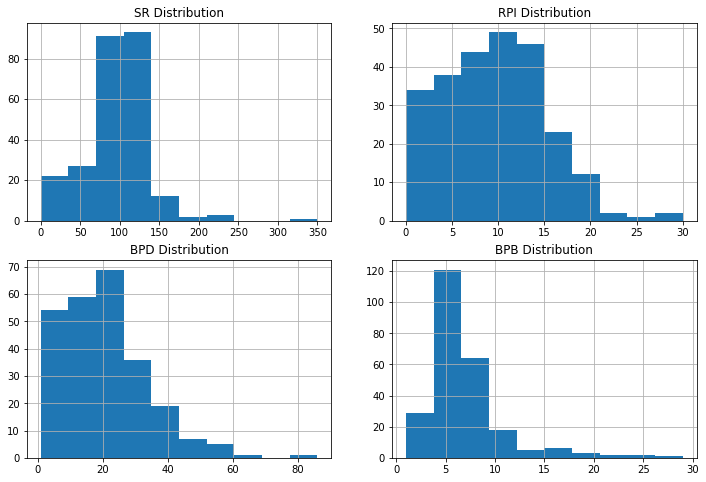

In [29]:
plt.figure(figsize = (12, 8))

plt.subplot(221)
pp_df.SR.hist()
plt.title('SR Distribution')

plt.subplot(222)
pp_df.RPI.hist()
plt.title('RPI Distribution')

plt.subplot(223)
pp_df.BPD.hist()
plt.title('BPD Distribution')

plt.subplot(224)
pp_df.BPB.hist()
plt.title('BPB Distribution')

plt.show()

In [37]:
import seaborn as sns

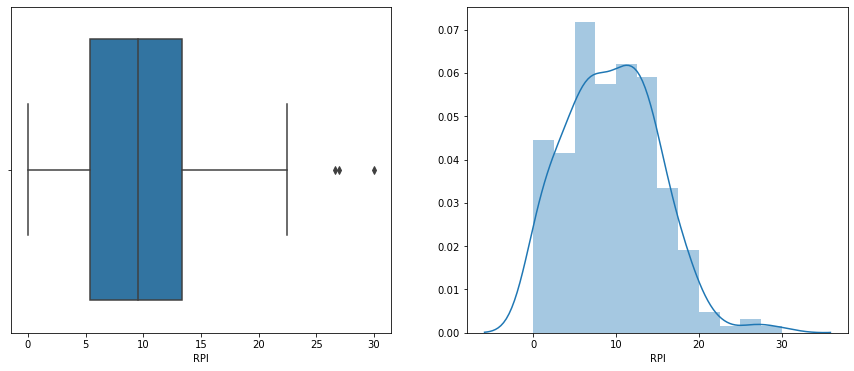

In [44]:
plt.figure(figsize = (15, 6))

plt.subplot(121)
sns.boxplot(pp_df['RPI'])

plt.subplot(122)
sns.distplot(pp_df['RPI'])
plt.show()

In [46]:
# np.percentile(pp_df['RPI'], 25), np.percentile(pp_df['RPI'], 50), np.percentile(pp_df['RPI'], 95)

### Pair wise comparision matrices using Saaty scale & then arriving at weights for each parameter

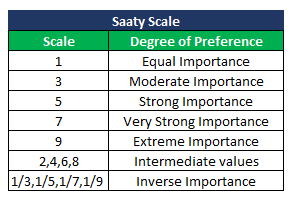

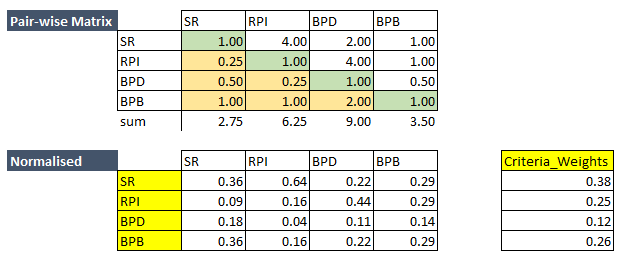

In [47]:
wt_sr, wt_rpi, wt_bpd, wt_bpb = 0.38, 0.25, 0.12, 0.26

In [48]:
# filter by min 5 innings
pp_df = pp_df[pp_df.innings >= 5]
pp_df.reset_index(inplace = True, drop = True)

### TOPSIS Method:

### (alternatives: minmax scaling, standard scaling)

### Calculation - Normalizing all values to same dimensions

In [49]:
pp_df['calc_SR'] = pp_df['SR'].apply(lambda x: x*x) 
pp_df['calc_RPI'] = pp_df['RPI'].apply(lambda x: x*x) 
pp_df['calc_BPD'] = pp_df['BPD'].apply(lambda x: x*x) 
pp_df['calc_BPB'] = pp_df['BPB'].apply(lambda x: x*x)

sq_sr, sq_rpi, sq_bpd, sq_bpb = np.sqrt(pp_df[['calc_SR','calc_RPI', 'calc_BPD', 'calc_BPB']].sum(axis = 0))

pp_df['calc_SR'] = pp_df['calc_SR'].apply(lambda x: x/sq_sr) 
pp_df['calc_RPI'] = pp_df['calc_RPI'].apply(lambda x: x/sq_rpi) 
pp_df['calc_BPD'] = pp_df['calc_BPD'].apply(lambda x: x/sq_bpd) 
pp_df['calc_BPB'] = pp_df['calc_BPB'].apply(lambda x: x/sq_bpb)

pp_df['calc_SR'] = pp_df['calc_SR'].apply(lambda x: x*wt_sr) 
pp_df['calc_RPI'] = pp_df['calc_RPI'].apply(lambda x: x*wt_rpi) 
pp_df['calc_BPD'] = pp_df['calc_BPD'].apply(lambda x: x*wt_bpd) 
pp_df['calc_BPB'] = pp_df['calc_BPB'].apply(lambda x: x*wt_bpb)

best_sr, worst_sr = max(pp_df['calc_SR']), min(pp_df['calc_SR'])
best_rpi, worst_rpi = max(pp_df['calc_RPI']), min(pp_df['calc_RPI'])
best_bpd, worst_bpd = max(pp_df['calc_BPD']), min(pp_df['calc_BPD'])
best_bpb, worst_bpb = min(pp_df['calc_BPB']), max(pp_df['calc_BPB'])

###  Calculation - Comparision against the best & worst values

In [50]:
pp_df['dev_best_SR'] = pp_df['calc_SR'].apply(lambda x: (x-best_sr)*(x-best_sr)) 
pp_df['dev_best_RPI'] = pp_df['calc_RPI'].apply(lambda x: (x-best_rpi)*(x-best_rpi)) 
pp_df['dev_best_BPD'] = pp_df['calc_BPD'].apply(lambda x: (x-best_bpd)*(x-best_bpd)) 
pp_df['dev_best_BPB'] = pp_df['calc_BPB'].apply(lambda x: (x-best_bpb)*(x-best_bpb))

pp_df['dev_best_sqrt'] = pp_df.apply(lambda x: x['dev_best_SR'] + x['dev_best_RPI'] + x['dev_best_BPD'] + x['dev_best_BPB'], axis = 1) 

pp_df['dev_worst_SR'] = pp_df['calc_SR'].apply(lambda x: (x-worst_sr)*(x-worst_sr)) 
pp_df['dev_worst_RPI'] = pp_df['calc_RPI'].apply(lambda x: (x-worst_rpi)*(x-worst_rpi)) 
pp_df['dev_worst_BPD'] = pp_df['calc_BPD'].apply(lambda x: (x-worst_bpd)*(x-worst_bpd)) 
pp_df['dev_worst_BPB'] = pp_df['calc_BPB'].apply(lambda x: (x-worst_bpb)*(x-worst_bpb))

pp_df['dev_worst_sqrt'] = pp_df.apply(lambda x: x['dev_worst_SR'] + x['dev_worst_RPI'] + x['dev_worst_BPD'] + x['dev_worst_BPB'], axis = 1) 

### Final Step - Overall score for each player ( values from 0 - 1)

In [51]:
pp_df['score'] = pp_df.apply(lambda x: x['dev_worst_sqrt']/(x['dev_worst_sqrt'] + x['dev_best_sqrt']), axis = 1)

In [52]:
pp_df[['batsman', 'score']].head()

,batsman,score
0,A Chopra,0.044514
1,A Symonds,0.207639
2,AA Jhunjhunwala,0.043430
3,AB de Villiers,0.330934
4,AC Blizzard,0.513533


### End Result: Top players for our required role

In [53]:
pp_df[[ 'batsman','innings', 'runs', 'balls', 'dismissals', 'fours', 'sixes', 'SR', 'BPB', 'score']].sort_values(['score'], ascending = False).reset_index(drop = True).head(25)

,batsman,innings,runs,balls,dismissals,fours,sixes,SR,BPB,score
0,CA Lynn,10,213,132,3,24,12,161.363636,3.666667,0.924301
1,SP Narine,12,222,131,10,34,10,169.465649,2.977273,0.906969
2,RA Tripathi,14,290,192,7,37,12,151.041667,3.918367,0.825882
3,Ishan Kishan,6,160,115,2,21,7,139.130435,4.107143,0.764341
4,MJ Lumb,12,225,157,6,37,5,143.312102,3.738095,0.737726
5,F du Plessis,31,507,364,8,64,18,139.285714,4.439024,0.717195
6,YK Pathan,31,342,241,11,44,16,141.908714,4.016667,0.701598
7,JC Buttler,14,226,161,6,29,10,140.372671,4.128205,0.696185
8,V Sehwag,103,1593,1160,60,230,46,137.327586,4.202899,0.644406
9,UT Khawaja,6,107,79,3,13,3,135.443038,4.937500,0.629735
